In [1]:
%reset -f
# Choix du label 

label = 'Label_2'
nombre_labels = 5

#label = 'Label_1'
#nombre_labels = 4

In [2]:
# Importing standard libraries for every machine/deep learning pipeline
import pandas as pd
import torch
from tqdm import tqdm, trange
import numpy as np


# Importing specific libraries for data prerpcessing, model archtecture choice, training and evaluation
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import AdamW

import matplotlib.pyplot as plt

from numpy.random import seed

In [3]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# 5. Pytorch random number generator
torch.manual_seed(seed_value)

In [4]:
# Defining constants
epochs = 6
MAX_LEN = 128
batch_size = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [5]:
# Load the dataset

df_training = pd.read_csv('Projet_Tweet_vaccin_fichier_1.1_labelises_pour_creer_la_fonction.csv', delimiter = ";", encoding = 'latin_1')
df_validation = pd.read_csv('Projet_Tweet_vaccin_fichier_1.2_labelises_pour_tester_la_fonction.csv', delimiter = ";", encoding = 'latin_1')

In [6]:
df = pd.concat([df_training, df_validation])

In [7]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert/camembert-large',do_lower_case=True)

In [8]:
# Creates list of texts and labels
text = df['text'].to_list()
labels = df[label].to_list()

#user tokenizer to convert tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)ces into tokenizer
input_ids  = [tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN) for sent in text]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]  
    attention_masks.append(seq_mask)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [9]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=42, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [10]:
# Load CamembertForSequenceClassification, the pretrained camembert model with a single linear classification layer on top. 
model = CamembertForSequenceClassification.from_pretrained('camembert/camembert-large', num_labels = nombre_labels)
model.to(device)

Some weights of the model checkpoint at camembert/camembert-large were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert/camembert-large and are newly initialized: ['cl

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
       

In [11]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=10e-8)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

C:\Users\cdcha\Anaconda3\envs\transformers8\lib\site-packages\transformers\optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [12]:
# Store our loss and accuracy for plotting if we want to visualize training evolution per epochs after the training process
train_loss_set = []
loss_train = []
accuracy_validation = []
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):  
    # Tracking variables for training
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs[0]
        # Add it to train loss list
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
    
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    loss_train.append(tr_loss/nb_tr_steps)
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Validation of the model
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]
    
        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    
    accuracy_validation.append(eval_accuracy/nb_eval_steps)
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Train loss: 1.4489217047338132


Epoch:  17%|█▋        | 1/6 [19:46<1:38:50, 1186.09s/it]

Validation Accuracy: 0.595072463768116
Train loss: 1.1067720232186493


Epoch:  33%|███▎      | 2/6 [39:28<1:18:54, 1183.65s/it]

Validation Accuracy: 0.518840579710145
Train loss: 0.9275520576371087


Epoch:  50%|█████     | 3/6 [59:09<59:08, 1182.77s/it]  

Validation Accuracy: 0.6095652173913043
Train loss: 0.633631357440242


Epoch:  67%|██████▋   | 4/6 [1:18:51<39:24, 1182.32s/it]

Validation Accuracy: 0.6034782608695651
Train loss: 0.4729824866409655


Epoch:  83%|████████▎ | 5/6 [1:38:32<19:41, 1181.83s/it]

Validation Accuracy: 0.6246376811594203
Train loss: 0.3275606566005283


Epoch: 100%|██████████| 6/6 [1:58:14<00:00, 1182.40s/it]

Validation Accuracy: 0.6713043478260868


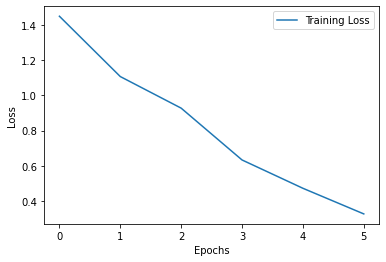

In [13]:
plt.plot(loss_train, label = 'Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('Training_loss.pdf')

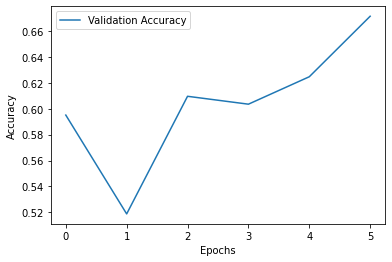

In [14]:
plt.plot(accuracy_validation, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('Validation_accuracy.pdf')

In [15]:
def logit_to_proba(x):

    x = 1/(1+np.exp(-logits))

    for i in range(x.shape[0]):
        x[i,:] = x[i,:]/np.sum(x[i,:])
    
    return x

In [16]:
tt = pd.read_csv('Projet_Tweet_vaccin_fichier_3_pour_tester_la_fonction.csv', delimiter = ";", 
                             encoding = 'latin_1')['text'].to_list()
comments = tt[0:3000]

In [17]:
# Encode the comments
tokenized_comments_ids = [tokenizer.encode(comment,add_special_tokens=True,max_length=MAX_LEN) for comment in comments]
# Pad the resulted encoded comments
tokenized_comments_ids = pad_sequences(tokenized_comments_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks 
attention_masks = []
for seq in tokenized_comments_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(tokenized_comments_ids)
prediction_masks = torch.tensor(attention_masks)

In [18]:
# Apply the finetuned model (Camembert)
flat_pred = []
with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs =  model(prediction_inputs.to(device),token_type_ids=None, attention_mask=prediction_masks.to(device))
    logits = outputs[0]
    logits = logits.detach().cpu().numpy() 
    flat_pred.extend(np.argmax(logits, axis=1).flatten())

In [19]:
df = pd.DataFrame(data={"tweet": comments, "classification": flat_pred})
df.to_csv("classification_label2.csv",index=False, sep=';')